Index-Building:
The factors used include the following:
- planet mass (Mjup)
- planet radius (Rjup)
- planet temperature (K)
- planet density CALCULATE
- radiation intensity (W/m^2) CALCULATE
- star distance (pc)
- AND/OR HZ measurement CALCULATE
- star metallicity ?? fraction
- star mass (Msun)
- sun radius (Rsun)
- star age ?? Gy
- star effective temperature (K)
- interactions?

The index will consist of the following:
- planet mass +
planet radius +
planet temperature +
star distance (HZ) + 
radiation intensity

Weighing can be determined in 1 of 2 ways:
- use a correlation regression as done in Cobb Douglas
- use difference from "ideal" Earth on a normal distribution to determine the importance of outliers
- tweaking post-factum to ensure earth is No.1

1. Import data and packages

In [217]:
# import packages
import numpy as np
import pandas as pd
import math 
from math import pi
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)  # None means no limit
pd.set_option('display.max_rows', None) 


# import data
data = pd.read_csv('../Data/exo_data.csv')

#display data
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

In [218]:
def map_value(value, from_min, from_max, to_min, to_max):
    """
    Maps a value from one range to another.

    Parameters:
    value (float): The value to be mapped.
    from_min (float): The minimum of the original range.
    from_max (float): The maximum of the original range.
    to_min (float): The minimum of the target range.
    to_max (float): The maximum of the target range.

    Returns:
    float: The value mapped to the target range.
    """
    # Calculate the proportion of the value within the original range
    proportion = (value - from_min) / (from_max - from_min)
    
    # Calculate the mapped value in the target range
    mapped_value = to_min + proportion * (to_max - to_min)
    
    return mapped_value

def index_from_min_ideal_max(value, mid_ideal, min_nonideal, max_nonideal, LB, UB, extrema = 0.1):

    # Case 0: value is ideal -> return 1
    if value == mid_ideal:
        return 1
    
    # Case 1: value is between ideal and max nonideal -> map value from -1 to -lowest score
    if mid_ideal < value < max_nonideal:
        index = 0 - map_value(value, mid_ideal, max_nonideal, -1, -extrema)
        return index
    
    # Case 2: value is between min nonideal and ideal -> map value value from 0.1 to 1
    if min_nonideal < value < mid_ideal:
        index = map_value(value, min_nonideal, mid_ideal, extrema, 1)
        return index
    
    # Case 3: value is between max nonideal and UB -> by definition the tempearture is non-ideal and would have scored 0.1
    #         however as it is past the max value map it to the range 0 -> 0.1 and subtract from 0.1 to get the final result
    if max_nonideal < value < UB:
        decrement = map_value(value, max_nonideal, UB, 0, extrema)
        index = extrema - decrement
        return index
    
    # Case 4: value is between LB and min nonideal -> by definition the value is non-ideal and woudld have scored 0.1
    #         however as it is less than min nonideal map it to the range -0.1 -> 0 and add it to 0.1 to get the final result
    if LB < value < min_nonideal:
        decrement = map_value(value, LB, min_nonideal, -extrema, 0)
        index = extrema + decrement
        return index
    
    return 666

def index_from_min_ideal(value, mid_ideal, min_nonideal, LB, extrema = 0.1):

    # Case 0: value is ideal -> return 1
    if value == mid_ideal:
        return 1
    
    # Case 1: value is between min nonideal and ideal -> map value value from 0.1 to 1
    if min_nonideal < value < mid_ideal:
        index = map_value(value, min_nonideal, mid_ideal, extrema, 1)
        return index
    
    # Case 2: value is between LB and min nonideal -> by definition the value is non-ideal and woudld have scored 0.1
    #         however as it is less than min nonideal map it to the range -0.1 -> 0 and add it to 0.1 to get the final result
    if LB < value < min_nonideal:
        decrement = map_value(value, LB, min_nonideal, -extrema, 0)
        index = extrema + decrement
        return index
    
    return 666

def index_from_ideal_max(value, mid_ideal, max_nonideal, UB, extrema = 0.1):

    # Case 0: value is ideal -> return 1
    if value == mid_ideal:
        return 1
    
    # Case 1: value is between ideal and max nonideal -> map value from -1 to -lowest score
    if mid_ideal < value < max_nonideal:
        index = 0 - map_value(value, mid_ideal, max_nonideal, -1, -extrema)
        return index
    
    # Case 2: value is between max nonideal and UB -> by definition the tempearture is non-ideal and would have scored 0.1
    #         however as it is past the max value map it to the range 0 -> 0.1 and subtract from 0.1 to get the final result
    if max_nonideal < value < UB:
        decrement = map_value(value, max_nonideal, UB, 0, extrema)
        index = extrema - decrement
        return index
    
    return 666

2. Calculate density

2.1 Convert: 
- M(jup) to M(earth)
- R(jup) to R(earth)

In [219]:
# M(jup) to M(earth)
def mjup_to_mearth(planet_mass_mjup):
    mass_mearth = planet_mass_mjup * 317.8 

    return mass_mearth

data['planet_mass_mearth'] = data.apply(lambda row: mjup_to_mearth(row['planet_mass_mjup']), axis = 1)



# R(jup) to R(earth)
def rjup_to_rearth(planet_radius_rjup):
    radius_rearth = planet_radius_rjup * 11.2

    return radius_rearth

data['planet_radius_rearth'] = data.apply(lambda row: rjup_to_rearth(row['planet_radius_rjup']), axis = 1)

# print(data)

2.2 Calculate volume 

In [220]:
# 4/3 * pi* r^3
def volume_formula(planet_radius_rearth):
    volume = (4/3) * np.pi * (planet_radius_rearth ** 3)

    return volume

data['planet_volume_rearth'] = data.apply(lambda row: volume_formula(row['planet_radius_rearth']), axis = 1)

# print(data)

3. Calculate Habitability Zone boundaries

3.2 Version 2: More complex

In [221]:
# Function to convert mass to luminosity 
def mass_to_luminosity(star_mass_msun):
    return star_mass_msun  ** 3.6


# Convert mass to luminosity 
data['Luminosity_Lsun'] = data['star_mass_msun'].apply(mass_to_luminosity) 



# inner flux 
def s_inner(Teff):
    s_inner = 1.296 - (2.139e-4 * Teff) + 4.19e-8 * (Teff**2)

    return s_inner

data['Flux_inner_HZ'] = data['star_teff_K'].apply(s_inner) 

# outer flux
def s_outer(Teff):
    s_outer = 0.234 - (1.319e-5 * Teff) + 6.19e-10 * (Teff**2)

    return s_outer

data['Flux_outer_HZ'] = data['star_teff_K'].apply(s_outer) 

# inner boundary
def r_inner(Luminosity_Lsun, Flux_inner_HZ):
    r_inner = np.sqrt(Luminosity_Lsun / Flux_inner_HZ)

    return r_inner

data['HZ_inner_AU'] = data.apply(lambda row: r_inner(row['Luminosity_Lsun'], row['Flux_inner_HZ']), axis = 1)


# outer boundary
def r_outer(Luminosity_Lsun, Flux_outer_HZ):
    r_outer = np.sqrt(Luminosity_Lsun / Flux_outer_HZ)

    return r_outer * 0.85

data['HZ_outer_AU'] = data.apply(lambda row: r_outer(row['Luminosity_Lsun'], row['Flux_outer_HZ']), axis = 1)

# print(data)

4. Calculate middle of HZ

In [222]:
def HZ_middle_ideal(HZ_inner, HZ_outer):
    HZ_middle = (HZ_inner + HZ_outer) / 2

    return HZ_middle

# data['HZ_middle_AU_s'] = data.apply(lambda row: HZ_middle_ideal(row['HZ_inner_AU_s'], row['HZ_outer_AU_s']), axis = 1)
data['HZ_middle_ideal_AU'] = data.apply(lambda row: HZ_middle_ideal(row['HZ_inner_AU'], row['HZ_outer_AU']), axis = 1)


5. Radiation Intensity
- Calculate distance from planet to star in m

In [223]:
def AU_to_m(star_distance_AU):
    star_distance_m = star_distance_AU * 1.496e+11

    return star_distance_m

data['star_distance_m'] = data['star_distance_AU'].apply(AU_to_m) 


In [224]:
# radiation = L / 4pi(r)^2 W/m^2
def radiation_I(luminosity, distance_m):
    radiation_I = luminosity / (4*np.pi*((distance_m)**2))

    return radiation_I

data['radiation_I'] = data.apply(lambda row: radiation_I(row['Luminosity_Lsun'], row['star_distance_m']), axis = 1)

5. Calculate pre-main sequence time and main-sequence lifetime for given stars. ideal = middle main sequence, non-ideal = pre or post-main sequence

5.1 Calculate pre-main sequence phase (tPMS)

In [225]:
def pre_seq_GY(star_mass_msun):
    pre_seq_length = ( 10e7*(star_mass_msun**-2.5) ) / 10e9

    return pre_seq_length

data['pre_seq_GY'] = data['star_mass_msun'].apply(pre_seq_GY) 
# print(data)

5.2 Calculate main-sequence lifetime (tMS)

In [226]:
def main_seq_GY(star_mass_msun):
    main_seq_length = 10*(1/(star_mass_msun**2.5))

    return main_seq_length

data['main_seq_GY'] = data['star_mass_msun'].apply(main_seq_GY) 

# print(data)

5.3 Calculate end of main sequence phase (transition into post-main sequence)

In [227]:
data['main_seq_end_GY'] = data['pre_seq_GY'] + data['main_seq_GY']

# print(data)

5.4 Calculate mid-main sequence time

In [228]:
def mid_main_seq_GY(main_seq_end_GY, pre_seq_GY):
    mid_main_seq = (main_seq_end_GY - pre_seq_GY) / 2

    return mid_main_seq

data['mid_main_seq_GY'] = data.apply(lambda row: mid_main_seq_GY(row['main_seq_end_GY'], row['pre_seq_GY']), axis = 1)
# print(data)

6. Calculate water potential !!!!

FOUND A WAY TO DO THIS:
- change everything from mearth to kg, m etc
- use jeans escape parameter to make this 

In [259]:
data['planet_mass_kg'] = data['planet_mass_mearth'] * 5.9722e24
data['planet_radius_m'] = data['planet_radius_rearth'] * (6378.137 * 1000)
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

THIS WORKS BUT NEEDS TO BE NORMALISED AND IDK WHERE

In [280]:
import math

# Constants
k_gravity = 6.67430e-11  # Gravitational constant, m^3 kg^-1 s^-1
k_Boltzman = 1.380649e-23  # Boltzmann constant, J K^-1
AU = 1.496e11  # Astronomical unit in meters
molecular_mass=4.65e-26 # N2
earth_mass=5.972e24
earth_radius=6.371e6
L_sun = 3.828e26 

# Functions to calculate necessary parameters
"""
Calculate the surface gravity of the planet.
mass: Mass of the planet in kg == Mearth?
radius: Radius of the planet in meters == Rearth
"""
def calculate_surface_gravity(mass, radius):
    grav = (k_gravity * (mass*earth_mass) / (radius*earth_radius)**2) * 1000
    grav_earth = grav / 9.81
    return grav



"""
Calculate the escape velocity of the planet.
mass: Mass of the planet in kg
radius: Radius of the planet in meters
"""
def calculate_escape_velocity(mass, radius):
   
    return math.sqrt(2 * k_gravity * (mass*earth_mass) / (radius*earth_radius))

data['escape_velocity'] = data.apply(lambda row: calculate_escape_velocity(row['planet_mass_mearth'], row['planet_radius_rearth']), axis = 1)



"""
Calculate the thermal velocity of atmospheric molecules.
temperature: Surface temperature in Kelvin
molecular_mass: Mass of the gas molecule in kg (for N2, approximately 4.65e-26 kg)
"""
def calculate_thermal_velocity(temperature, molecular_mass):
    return math.sqrt((3 * k_Boltzman * temperature )/ molecular_mass)

data['thermal_velocity'] = data.apply(lambda row: calculate_thermal_velocity(row['temp_calculated_K'], 4.65e-26), axis = 1)



'''
calculate jeans escape parameter 
JEP = (GMm / kTR)
'''

def atmospheric_retention(escape_velocity, thermal_velocity):
    jeans_parameter = (escape_velocity**2)/ (2*(thermal_velocity**2))

    if jeans_parameter <= 5:
        jeans_parameter = 0
    else:
        jeans_parameter = jeans_parameter

    return jeans_parameter

data['jeans_parameter'] = data.apply(lambda row: atmospheric_retention(row['escape_velocity'], row['thermal_velocity']), axis = 1)
data['jeans_parameter_norm'] = (data['jeans_parameter'] -0 )/ (np.max(data['jeans_parameter'])-0)


"""
Determine if the planet is within the habitable zone of its star.
distance: Distance from the star in AU
luminosity: Luminosity of the star in watts
"""
def is_in_habitable_zone(distance, luminosity, temperature):
    inner_boundary = math.sqrt((luminosity) / (1.296 - (2.139e-4 * temperature) + 4.19e-8 * (temperature**2)))
    outer_boundary = math.sqrt((luminosity) / ( 0.234 - (1.319e-5 * temperature) + 6.19e-10 * (temperature**2)))
    return inner_boundary <= distance <= outer_boundary


"""
Evaluate the probability of the planet being able to sustain liquid water.
mass: Mass of the planet in kg
radius: Radius of the planet in meters
distance: Distance from the star in AU
temperature: Surface temperature in Kelvin
luminosity: Luminosity of the star in watts (default is Sun-like)
molecular_mass: Mass of the atmospheric gas molecule in kg (default is for nitrogen, N2)
"""
def evaluate_water_sustenance(mass, radius, distance, temperature, luminosity,  jeans_parameter_norm, molecular_mass= 4.65e-26):
    gravity = calculate_surface_gravity(mass, radius)
    escape_velocity = calculate_escape_velocity(mass, radius)
    thermal_velocity = calculate_thermal_velocity(temperature, molecular_mass)
    in_habitable_zone = is_in_habitable_zone(distance, luminosity, temperature)
    #jeans_parameter = jeans_parameter(escape_velocity, thermal_velocity)
    
    # Surface gravity assessment (reasonable range 0.38g to 2g where g is Earth's gravity)
    #gravity_assessment = (0.38 * 9.81) <= gravity <= (2 * 9.81)
    gravity_contribution = index_from_min_ideal_max(gravity, 9.81, 0.38 * 9.81, 2 * 9.81, 0.0 * 9.81, 300000 * 9.81)

    
    # Atmospheric retention assessment (escape velocity should be much higher than thermal velocity)
    
    
    # atmospheric_retention = 0 if thermal_velocity == 0 else escape_velocity > 10 * thermal_velocity
    
    # Surface temperature assessment (within 0°C to 100°C for liquid water)
    #temperature_assessment = 273 <= temperature <= 373
    temperature_contribution = index_from_min_ideal_max(temperature, 300, 250, 400, 0, 5000, 0.1)
    
    # Combine assessments into a probability category
    """
    if in_habitable_zone and temperature_assessment and atmospheric_retention and gravity_assessment:
        return 0.75
    elif in_habitable_zone and (temperature_assessment or atmospheric_retention or gravity_assessment):
        return 0.5
    else:
        return 0.25
    """
    index = (in_habitable_zone + temperature_contribution + jeans_parameter_norm + gravity_contribution) * 0.25
    return index

# Example use case:
# data['mid_main_seq_GY'] = data.apply(lambda row: mid_main_seq_GY(row['main_seq_end_GY'], row['pre_seq_GY']), axis = 1)


data["water"] = data.apply(lambda row: evaluate_water_sustenance(row['planet_mass_mearth'], row['planet_radius_rearth'], row['star_distance_AU'], row['temp_calculated_K'],row['Luminosity_Lsun'], row['thermal_velocity'], row['jeans_parameter_norm']), axis = 1)
    #evaluate_water_sustenance(planet_mass, planet_radius, distance_from_star, surface_temperature)
print(data)


          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

6. Calculate ideal and non-ideal values ??

- planet mass M(earth) == Earth? between 0.5 and 5 earth masses as can maintain atmosphere and possibly have H2O (aq)
- planet radius R(earth) == Earth? between 0.8 and 1.5 earth radii as above might have thick gas envelopes and be more like mini-neptures/gas giant
- planet temperature (K) == Earth? between 0 and 100'c where water can remain liquid as standard pressure
- planet density == Earth? between 5 and 5.5 g/cm3
- radiation intensity (W/m^2) == Earth ? limits at HZ?
- HZ measurement == normal distribution, y = middle of HZ; non ideal = | 2sigma | where 1.5 sigma == boundary 
- star age ?? Gy maybe calculate lifetime based on Tms = 10gy * (1/(Mstar^2.5))  where Tms is main sequence lifetime. Pre-main sequence phase tpms = 10^7 * M^-2.5
- interactions??

In [231]:
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

6.1 Mass, radius etc ideal and non-ideal values -> in water index?

6.3 Temperature ideal and non-ideal values

In [232]:
# calculate temperature in C

def K_to_C(temp_calculated_K):

    temp_calculated_C = temp_calculated_K - 273

    return temp_calculated_C
data['temp_calculated_C'] = data['temp_calculated_K'].apply(K_to_C) 


## ideal = 20 X
## non ideal: 0 and 100

In [233]:

def map_temperature(temperature):
    ideal = 15
    min = -40
    max = 200
    LB = -273
    UB = 5000
    return index_from_min_ideal_max(temperature, ideal, min, max, LB, UB)


data['map_temperature'] = data['temp_calculated_C'].apply(map_temperature) 
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

6.5 HZ normal distribution; ideal and non-ideal values !!! needs work

FOUDN HOW TO MAKE THIS WORK!!¬
- convert all to m, kg etc
- use jeans escape parameter

In [234]:
# Math is right, HZ outer is to big hence mars looks better
# Potentially recalculate HZ outer
def map_HZ(value, mid_ideal, min_nonideal, max_nonideal, d=1):
    # Calculate shifted max
    d_max = max_nonideal - mid_ideal
    shifted_max = 1.5*d_max + mid_ideal

    # Calculate shifted min
    d_min = mid_ideal - min_nonideal
    shifted_min = mid_ideal - 1.5*d_min

    # Calculate distances from ideal to min and max
    distance_min = mid_ideal - shifted_min
    distance_max = shifted_max - mid_ideal
    
    # Determine the position of the value relative to V_ideal and normalize to [0, d]
    if value <= mid_ideal:
        # Map values between V_min and V_ideal to [0, d]
        new_value = d * (mid_ideal - value) / distance_min
    else:
        # Map values between V_ideal and V_max to [0, d]
        new_value = d * (value - mid_ideal) / distance_max
    

    ## add if <0 then 0
    
    if new_value >=1:
        new_value = 1
    elif new_value <=0:
        new_value = 0
    else:
        new_value = new_value

    return d/2 + (d/2 - new_value)

def map_HZ_new(value, ideal, min, max, LB=0, UB=8000): # Double check the boundary values
    return index_from_min_ideal_max(value, ideal, min, max, LB, UB)



data['map_HZ'] = data.apply(lambda row: map_HZ_new(row['star_distance_AU'], row['HZ_middle_ideal_AU'], row['HZ_inner_AU'], row['HZ_outer_AU']), axis = 1)
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

6.6 Star age ideal and non-ideal values !!! Soething fucked up and now values are weird!!!

In [235]:
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

In [236]:
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

AGE VERSION 2

In [237]:
# ideal = mid_main_seq_GY  
# non ideal: > main_seq_end_GY  OR < pre_seq_GY

def map_star_age(value, age_ideal, main_seq_LB, main_seq_UB, d=1): # age_max_ms_end
   
    # Calculate distances from ideal to min and max
    distance_min = age_ideal - main_seq_LB
    distance_max = main_seq_UB - age_ideal
    
    # Determine the position of the value relative to V_ideal and normalize to [0, d]
    if value <= age_ideal >= main_seq_LB:
        new_value = d * (age_ideal - value) / distance_min

    elif value <= main_seq_LB:
        new_value = (-d) * ((age_ideal - value) / (age_ideal))
    
    elif value >= age_ideal <=main_seq_UB:
        new_value = d * (value - age_ideal) / distance_max

    else:
        new_value = (-d) * ((value - age_ideal) / (2*age_ideal))
    
    return d/2 + (d/2 - new_value)

def map_star_age_new(value, ideal, min, max, LB = 0, UB = 20000): # Same here, check the lower and upper boundaries.
    return index_from_min_ideal_max(value, ideal, min, max, LB, UB)


data['map_star_age'] = data.apply(lambda row: map_star_age_new(row['star_age_Gy'], row['mid_main_seq_GY'], row['pre_seq_GY'], row['main_seq_end_GY']), axis = 1)
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

In [238]:
# data['star_distance']

7. Join together:
- water 
- - (mass , radius, temp, mol mass, distance, luminosity).
- - mass, radius => surface gravity 
- - mass, radius => escape velocity
- - temperature, mol mass (N2) => thermal velocity
- - star distance, luminosity => HZ
- - - then assess:
- - - gravity
- - - thermal velocity + escape velocity => atmospheric retention
- - - temperature


- map_temperature (temp K)


- map_radiation (luminosity, star distance) 
- - not too important


- map_HZ (luminosity, star distance)
- - luminosity => flux => boundaries

- map_star_age (age)

In [239]:
"""
def HUIndex(water, temp, radiation, HZ, star_age, weight_water = None, weight_temp = None, weight_radiation = None, weight_HZ = None, weight_star_age = None):
    weighting = [weight_water, weight_temp, weight_radiation, weight_HZ, weight_star_age]

# sum of weights
    sum_provided_weights = 0
# ask about user weighing
    if weight_water is None:
        weight_water = float(input("What is the weighing for the liquid water potential factor? "))
        sum_provided_weights += weight_water
    else:
        sum_provided_weights += weight_water
    if weight_temp is None:
        weight_temp = float(input("What is the weighing for the surface temperature factor? "))
        sum_provided_weights += weight_temp
    else:
        sum_provided_weights += weight_temp
    if weight_radiation is None:
        weight_radiation = float(input("What is the weighing for the surface radiation factor? "))
        sum_provided_weights += weight_radiation
    else:
        sum_provided_weights += weight_radiation
    if weight_HZ is None:
        weight_HZ = float(input("What is the weighing for the Habitability Zone factor? "))
        sum_provided_weights += weight_HZ
    else:
        sum_provided_weights += weight_HZ
    if weight_star_age is None:
        weight_star_age = float(input("What is the weighing for the star age factor? "))
        sum_provided_weights += weight_star_age
    else:
        sum_provided_weights += weight_star_age

    if sum_provided_weights > 1:
        print('The sum of provided weights is {sum_provided_weights}, which is greater than 1. /n Please provide new exponents  ')
    

    HUI = (water** weight_water) * (temp**weight_temp) * (radiation**weight_radiation) * (HZ ** weight_HZ) * (star_age ** weight_star_age)
    return HUI
     
    
data['HUI'] = data.apply(lambda row: HUIndex(row['water'], row['map_temperature'], row['map_radiation'], row['map_HZ'], row['map_star_age']), axis = 1)
print(data)
"""

'\ndef HUIndex(water, temp, radiation, HZ, star_age, weight_water = None, weight_temp = None, weight_radiation = None, weight_HZ = None, weight_star_age = None):\n    weighting = [weight_water, weight_temp, weight_radiation, weight_HZ, weight_star_age]\n\n# sum of weights\n    sum_provided_weights = 0\n# ask about user weighing\n    if weight_water is None:\n        weight_water = float(input("What is the weighing for the liquid water potential factor? "))\n        sum_provided_weights += weight_water\n    else:\n        sum_provided_weights += weight_water\n    if weight_temp is None:\n        weight_temp = float(input("What is the weighing for the surface temperature factor? "))\n        sum_provided_weights += weight_temp\n    else:\n        sum_provided_weights += weight_temp\n    if weight_radiation is None:\n        weight_radiation = float(input("What is the weighing for the surface radiation factor? "))\n        sum_provided_weights += weight_radiation\n    else:\n        sum_p

In [240]:
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

In [241]:
"""
def HUIndex(water, temp, radiation, HZ, star_age, weight_water=None, weight_temp=None, weight_radiation=None, weight_HZ=None, weight_star_age=None):
    
    Calculate the Habitability Index using provided factors and weights.
    
    Parameters:
    - water (float): Water factor.
    - temp (float): Temperature factor.
    - radiation (float): Radiation factor.
    - HZ (float): Habitability Zone factor.
    - star_age (float): Age of the star.
    - weight_water (float, optional): Weight for water factor.
    - weight_temp (float, optional): Weight for temperature factor.
    - weight_radiation (float, optional): Weight for radiation factor.
    - weight_HZ (float, optional): Weight for habitability zone factor.
    - weight_star_age (float, optional): Weight for star age factor.
    
    Returns:
    - float: The computed Habitability Index or None if the weights are invalid.
    
    
    # List of all weights and factors
    weights = [weight_water, weight_temp, weight_radiation, weight_HZ, weight_star_age]
    factor_names = ["water", "temperature", "radiation", "habitability zone", "star age"]
    num_factors = len(weights)

    # Determine the provided weights
    provided_weights = [w for w in weights if w is not None]
    sum_provided_weights = sum(provided_weights)
    
    # Function to prompt for missing weights
    def prompt_for_weights():
        for i in range(num_factors):
            if weights[i] is None:
                while True:
                    try:
                        weight_input = float(input(f"Enter the weight for {factor_names[i]} factor (a positive number, current sum of weights: {sum([w for w in weights if w is not None]):.2f}): "))
                        if weight_input < 0:
                            raise ValueError("Weight must be non-negative.")
                        weights[i] = weight_input
                        break
                    except ValueError as e:
                        print(f"Invalid input. {e}")
    
    # Prompt for weights if any are missing
    while None in weights:
        print("Please provide weights for the factors.")
        prompt_for_weights()
    
    # Calculate the sum of provided weights
    sum_provided_weights = sum([w for w in weights if w is not None])
    
    # Provide feedback to the user and validate the weights
    if sum_provided_weights > 1:
        print(f"The sum of the provided weights is {sum_provided_weights}, which is greater than 1. Please adjust them so they sum to 1.")
        return None
    elif sum_provided_weights < 1:
        remaining_weight = 1 - sum_provided_weights
        missing_weights = weights.count(None)
        if missing_weights > 0:
            # Distribute the remaining weight equally among the missing weights
            equal_weight = remaining_weight / missing_weights
            for i in range(num_factors):
                if weights[i] is None:
                    weights[i] = equal_weight
        else:
            print(f"The sum of the provided weights is {sum_provided_weights}.")
            print(f"Adjusting the last weight by adding the remaining weight {remaining_weight:.4f} to it.")
            weights[-1] += remaining_weight
    
    print(f"Final weights: {weights}")

    # Calculate the Habitability Index using the weights
    habitability_index = (
        (water ** weights[0]) *
        (temp ** weights[1]) *
        (radiation ** weights[2]) *
        (HZ ** weights[3]) *
        (star_age ** weights[4])
    )

    return habitability_index

data['HUI'] = data.apply(lambda row: HUIndex(row['water'], row['map_temperature'], row['map_radiation'], row['map_HZ'], row['map_star_age']), axis = 1)
print(data)
"""

'\ndef HUIndex(water, temp, radiation, HZ, star_age, weight_water=None, weight_temp=None, weight_radiation=None, weight_HZ=None, weight_star_age=None):\n    \n    Calculate the Habitability Index using provided factors and weights.\n    \n    Parameters:\n    - water (float): Water factor.\n    - temp (float): Temperature factor.\n    - radiation (float): Radiation factor.\n    - HZ (float): Habitability Zone factor.\n    - star_age (float): Age of the star.\n    - weight_water (float, optional): Weight for water factor.\n    - weight_temp (float, optional): Weight for temperature factor.\n    - weight_radiation (float, optional): Weight for radiation factor.\n    - weight_HZ (float, optional): Weight for habitability zone factor.\n    - weight_star_age (float, optional): Weight for star age factor.\n    \n    Returns:\n    - float: The computed Habitability Index or None if the weights are invalid.\n    \n    \n    # List of all weights and factors\n    weights = [weight_water, weight

7. Normalise decision matrix ?

8. Weighing
Weighing can be determined in 1 of 2 ways:
- use a correlation regression as done in Cobb Douglas
- use difference from "ideal" Earth on a normal distribution to determine the importance of outliers

9. Seperation measures - distance to ideal and non-ideal
- likely to include creation of a completely new dataset for comparison of EACH exoplanet

10. Relative closeness to ideal

11. Comparison to Earth etc
Would be good to add a visual aspect:
- maybe an image with 'sliders' showing where points are from ideal?
- sliders with different parts of HUI in different colours to show where a planet fell through 

Future directions:
- percentile on normal

In [242]:
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

In [243]:
'''
def HUIndex(water, temp, C12_stability, HZ, star_age):
    
    weight_water = 0.3
    weight_temp = 0.2
    weight_C12 = 0.10
    weight_HZ = 0.3
    weight_star_age = 0.10
    

    HUI = (water)**weight_water + (temp)**weight_temp + (radiation)**weight_radiation + (HZ)**weight_HZ + (star_age)**weight_star_age
    return HUI

data['HUI'] = data.apply(lambda row: HUIndex(row['water'], row['map_temperature'], row['C12_'], row['map_HZ'], row['map_star_age']), axis = 1)
print(data)
'''

"\ndef HUIndex(water, temp, C12_stability, HZ, star_age):\n    \n    weight_water = 0.3\n    weight_temp = 0.2\n    weight_C12 = 0.10\n    weight_HZ = 0.3\n    weight_star_age = 0.10\n    \n\n    HUI = (water)**weight_water + (temp)**weight_temp + (radiation)**weight_radiation + (HZ)**weight_HZ + (star_age)**weight_star_age\n    return HUI\n\ndata['HUI'] = data.apply(lambda row: HUIndex(row['water'], row['map_temperature'], row['C12_'], row['map_HZ'], row['map_star_age']), axis = 1)\nprint(data)\n"

Correlation analysis

In [244]:
"""
import numpy as np
import scipy.stats as stats
from scipy.special import betainc
import matplotlib.pyplot as plt
import seaborn as sns

selected_columns = ['water', 'map_temperature', 'map_radiation', 'map_HZ', 'map_star_age']
data_cor = data[selected_columns]

numeric_data_cor = data_cor.select_dtypes(include=[np.number])

correlation_matrix = numeric_data_cor.corr()

def calculate_p_value(r,n):
    df = n - 2
    t_squared = r**2 * (df/(1-r**2))
    p_value = betainc(0.5 * df, 0.5, df/(df + t_squared))
    return p_value


p_values = pd.DataFrame(np.zeros((numeric_data_cor.shape[1], numeric_data_cor.shape[1])), columns=numeric_data_cor.columns, index=numeric_data_cor.columns)

for col1 in numeric_data_cor.columns:
    for col2 in numeric_data_cor.columns:
        if col1 != col2:
            # Calculate Pearson correlation
            r = correlation_matrix.loc[col1, col2]
            # Number of observations
            n = numeric_data_cor.shape[0]
            # Calculate p-value
            p_val = calculate_p_value(r, n)
            p_values.loc[col1, col2] = p_val
        else:
            p_values.loc[col1, col2] = np.nan  # or 1, since a variable is perfectly correlated with itself


print(p_values)
plt.figure(figsize=(5, 5))  # Set the size of the plot
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={"shrink": .8})
heatmap.xaxis.set_ticks_position('top')
heatmap.xaxis.set_label_position('top')  # Move the x-axis label to the top
plt.xticks(rotation=45, ha='left') 

# Add title and labels
plt.title('Correlation Matrix Heatmap')
plt.xlabel('Factors')
plt.ylabel('Factors')

# Display the plot
plt.show()
"""

'\nimport numpy as np\nimport scipy.stats as stats\nfrom scipy.special import betainc\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\nselected_columns = [\'water\', \'map_temperature\', \'map_radiation\', \'map_HZ\', \'map_star_age\']\ndata_cor = data[selected_columns]\n\nnumeric_data_cor = data_cor.select_dtypes(include=[np.number])\n\ncorrelation_matrix = numeric_data_cor.corr()\n\ndef calculate_p_value(r,n):\n    df = n - 2\n    t_squared = r**2 * (df/(1-r**2))\n    p_value = betainc(0.5 * df, 0.5, df/(df + t_squared))\n    return p_value\n\n\np_values = pd.DataFrame(np.zeros((numeric_data_cor.shape[1], numeric_data_cor.shape[1])), columns=numeric_data_cor.columns, index=numeric_data_cor.columns)\n\nfor col1 in numeric_data_cor.columns:\n    for col2 in numeric_data_cor.columns:\n        if col1 != col2:\n            # Calculate Pearson correlation\n            r = correlation_matrix.loc[col1, col2]\n            # Number of observations\n            n = numeric_data_cor.s

HUIndex interactions

In [245]:
'''
# pip install matplotlib
import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

categories = HUI_data.columns[1:]  # ['Category1', 'Category2', ..., 'Category7']
bar_width = 0.1
index = np.arange(len(HUI_data))

for i, category in enumerate(categories):
    values = HUI_data[category]
    ax.bar(index + i * bar_width, values, bar_width, label=category)

# Set ticks and labels
ax.set_xticks(index + bar_width * (len(categories) - 1) / 2)
#ax.set_xticklabels(df['Metric'])  # Use metrics for x-axis labels

# Optional: Add legend, title, and labels
ax.legend()
ax.set_xlabel('Planets')
ax.set_ylabel('Index')

# Show the plot
plt.show()
'''


"\n# pip install matplotlib\nimport matplotlib.pyplot as plt\n\n# Plotting\nfig, ax = plt.subplots(figsize=(10, 6))\n\ncategories = HUI_data.columns[1:]  # ['Category1', 'Category2', ..., 'Category7']\nbar_width = 0.1\nindex = np.arange(len(HUI_data))\n\nfor i, category in enumerate(categories):\n    values = HUI_data[category]\n    ax.bar(index + i * bar_width, values, bar_width, label=category)\n\n# Set ticks and labels\nax.set_xticks(index + bar_width * (len(categories) - 1) / 2)\n#ax.set_xticklabels(df['Metric'])  # Use metrics for x-axis labels\n\n# Optional: Add legend, title, and labels\nax.legend()\nax.set_xlabel('Planets')\nax.set_ylabel('Index')\n\n# Show the plot\nplt.show()\n"

In [246]:
#data.to_csv('C:/Users/21sko/Desktop/dissertation/data/results_3.csv', index=False)


AFTER CHECK-IN WITH JAVIER
- need to add albedo
- need to get rid of radiation
- need to rename HZ ?
- need to think about potentially adding carbon stability
- need to create a playground to work on interactions

CARBON 12

In [247]:
# carbon is stable for bonding between 200 and 500 K
# and at stellar radiastion 0.8 or above

SOMETHING IS WRONG HERE - HOW IS MERCURY BETTER THAN MARS???????????

In [248]:
def C_stability_temp(temperature, mid_ideal = 288, min_nonideal = 200, max_nonideal = 500, d=1):

    def map_value(value, from_min, from_max, to_min, to_max):
        """
        Maps a value from one range to another.

        Parameters:
        value (float): The value to be mapped.
        from_min (float): The minimum of the original range.
        from_max (float): The maximum of the original range.
        to_min (float): The minimum of the target range.
        to_max (float): The maximum of the target range.

        Returns:
        float: The value mapped to the target range.
        """
        # Calculate the proportion of the value within the original range
        proportion = (value - from_min) / (from_max - from_min)
        
        # Calculate the mapped value in the target range
        mapped_value = to_min + proportion * (to_max - to_min)
        
        return mapped_value

    # Calculate shifted max
    '''
    mid_ideal = 350
    min_nonideal = 200
    max_nonideal = 500 
    '''
    LB = 0
    UB = 5500

    # Case 0: temperature is ideal -> return 1
    if temperature == mid_ideal:
        return 1
    
    # Case 1: temperature is between ideal and max nonideal -> map temperature value from -1 to -0.1
    if mid_ideal < temperature < max_nonideal:
        index = 0 - map_value(temperature, mid_ideal, max_nonideal, -1, -0.1)
        return index
    
    # Case 2: temperature is between min nonideal and ideal -> map temperature value from 0.1 to 1
    if min_nonideal < temperature < mid_ideal:
        index = map_value(temperature, min_nonideal, mid_ideal, 0.1, 1)
        return index
    
    # Case 3: temperature is between max nonideal and UB -> by definition the tempearture is non-ideal and would have scored 0.1
    #         however as it is past the max value map it to the range 0 -> 0.1 and subtract from 0.1 to get the final result
    if max_nonideal < temperature < UB:
        decrement = map_value(temperature, max_nonideal, UB, 0, 0.1)
        index = 0.25 - decrement
        return index
    
    # Case 4: temperature is between LB and min nonideal -> by definition the temperature is non-ideal and woudld have scored 0.1
    #         however as it is less than min nonideal map it to the range -0.1 -> 0 and add it to 0.1 to get the final result
    if LB < temperature < min_nonideal:
        decrement = map_value(temperature, LB, min_nonideal, -0.1, 0)
        index = 0.25 + decrement
        return index

data['C_stability_temp'] =  data['temp_calculated_K'].apply(C_stability_temp) 

print(data)
                

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

12C - RADIATION PART

In [249]:
data['relative_r'] = data['radiation_I'] / 3.552342e-24
print(data['relative_r'])

0     6.668000e-10
1     1.250130e+02
2     5.476791e+02
3     4.075502e-03
4     9.122377e-01
5     3.855604e+03
6     6.580865e+00
7     1.930844e+00
8     4.331696e-01
9     3.704759e-02
10    1.092761e-02
11    3.383415e-03
12    1.104789e-03
13    1.000950e+00
Name: relative_r, dtype: float64


!!! FAILS TO WORK INDEX WISE

In [250]:

def C_stability_radiation(relative_r, mid_ideal = 1, min_nonideal = 0.8, max_nonideal = 5, d=1):
    # relative_r = radiation / (3.552342e-24) 
    # print(relative_r)

    d_max = max_nonideal - mid_ideal
    d_min = mid_ideal - min_nonideal

        # Determine the position of the value relative to V_ideal and normalize to [0, d]
    if  min_nonideal < relative_r < mid_ideal:
        new_value = d * (mid_ideal - relative_r) / d_min
    elif max_nonideal > relative_r > mid_ideal:
        new_value = d * (relative_r - mid_ideal) / d_max
    elif relative_r < min_nonideal:
        new_value = (-d) * ((mid_ideal - relative_r) / (mid_ideal - 0))
    else:
        new_value = (-d) * ((relative_r - mid_ideal) / ((5*max_nonideal)- mid_ideal))
        '''
    elif relative_r > max_nonideal:
        new_value = (-d) * ((temperature - mid_ideal) / (max_nonideal- mid_ideal))
        
    else:
        # Map values between V_ideal and V_max to [0, d]
        new_value = 0
     '''
    if new_value < 0:
        return new_value
    elif new_value > 0:
        return 1 - new_value
    elif new_value == 0:
        return 1
    
    return new_value

def C_stability_radiation_new(value, ideal = 1, min = 0.8, max = 5, LB = 0, UB = 4000):
    return index_from_min_ideal_max(value, ideal , min, max, LB, UB)
    

    
data['C_stability_radiation'] =  data['relative_r'].apply(C_stability_radiation_new) 
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

12C stability index

In [251]:
def C12_stability(temp, radiation):
    stability = (temp + radiation) * 0.5
    return stability

data['C12_stability'] = data.apply(lambda row: C12_stability(row['C_stability_temp'], row['C_stability_radiation']), axis = 1)
print(data)

          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

INDEX

In [252]:
def HUIndex(water, temp, C12_stability, HZ, star_age):
    
    weight_water = 0.3
    weight_temp = 0.2
    weight_C12 = 0.10
    weight_HZ = 0.3
    weight_star_age = 0.10
    

    HUI = (water)**weight_water + (temp)**weight_temp + (C12_stability)**weight_C12 + (HZ)**weight_HZ + (star_age)**weight_star_age
    return HUI

data['HUI'] = data.apply(lambda row: HUIndex(row['water'], row['map_temperature'], row['C12_stability'], row['map_HZ'], row['map_star_age']), axis = 1)
print(data)


          planet  planet_mass_mjup  planet_radius_rjup  temp_calculated_K  \
0   COCONUTS-2 b          6.400000            1.120000             434.00   
1     HAT-P-18 b          0.183000            0.947000             841.00   
2     HAT-P-42 b          0.975000            1.277000            1427.00   
3    kappa And b         13.000000            1.200000            1850.00   
4   TRAPPIST-1 b          0.002700            0.096890             451.55   
5     WASP-189 b          1.990000            1.619000            3394.00   
6        Mercury          0.000174            0.034000             440.00   
7          Venus          0.002570            0.085000             737.00   
8           Mars          0.000338            0.047000             210.00   
9        Jupiter          1.000000            1.000000             165.00   
10        Saturn          0.299000            0.843000             134.00   
11        Uranus          0.046000            0.355000              76.00   

PLAYTIME w/ INTERACTIONS

                    water  map_temperature    map_HZ  map_star_age  \
water                 NaN         0.019751  0.009546      0.733369   
map_temperature  0.019751              NaN  0.409146      0.967638   
map_HZ           0.009546         0.409146       NaN      0.510123   
map_star_age     0.733369         0.967638  0.510123           NaN   
C12_stability    0.009187         0.000038  0.441875      0.908989   

                 C12_stability  
water                 0.009187  
map_temperature       0.000038  
map_HZ                0.441875  
map_star_age          0.908989  
C12_stability              NaN  


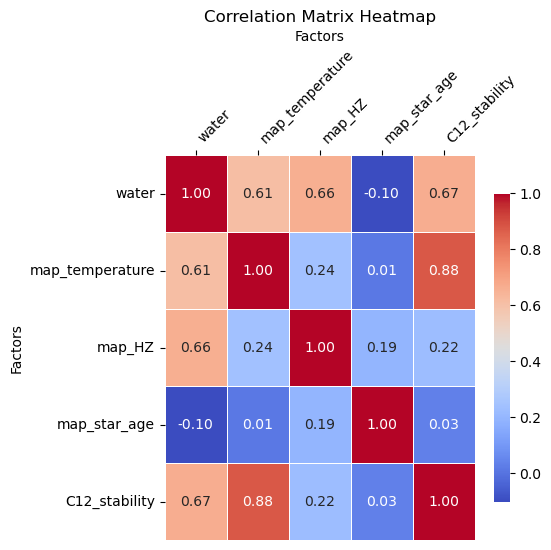

In [253]:
import numpy as np
import scipy.stats as stats
from scipy.special import betainc
import matplotlib.pyplot as plt
import seaborn as sns

selected_columns = ['water', 'map_temperature', 'map_HZ', 'map_star_age', 'C12_stability']
data_cor = data[selected_columns]

numeric_data_cor = data_cor.select_dtypes(include=[np.number])

correlation_matrix = numeric_data_cor.corr()

def calculate_p_value(r,n):
    df = n - 2
    t_squared = r**2 * (df/(1-r**2))
    p_value = betainc(0.5 * df, 0.5, df/(df + t_squared))
    return p_value


p_values = pd.DataFrame(np.zeros((numeric_data_cor.shape[1], numeric_data_cor.shape[1])), columns=numeric_data_cor.columns, index=numeric_data_cor.columns)

for col1 in numeric_data_cor.columns:
    for col2 in numeric_data_cor.columns:
        if col1 != col2:
            # Calculate Pearson correlation
            r = correlation_matrix.loc[col1, col2]
            # Number of observations
            n = numeric_data_cor.shape[0]
            # Calculate p-value
            p_val = calculate_p_value(r, n)
            p_values.loc[col1, col2] = p_val
        else:
            p_values.loc[col1, col2] = np.nan  # or 1, since a variable is perfectly correlated with itself


print(p_values)
plt.figure(figsize=(5, 5))  # Set the size of the plot
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={"shrink": .8})
heatmap.xaxis.set_ticks_position('top')
heatmap.xaxis.set_label_position('top')  # Move the x-axis label to the top
plt.xticks(rotation=45, ha='left') 

# Add title and labels
plt.title('Correlation Matrix Heatmap')
plt.xlabel('Factors')
plt.ylabel('Factors')

# Display the plot
plt.show()

In [254]:
results_lm = data[['water', 'map_HZ', 'C12_stability', 'map_temperature', 'map_star_age']]

print(results_lm)
#results_lm.to_csv('C:/Users/21sko/Desktop/dissertation/data/results_lm.csv', index=False)

       water    map_HZ  C12_stability  map_temperature  map_star_age
0   0.298737  0.019113       0.190094         0.289730      0.105331
1   0.297560  0.009996       0.170088         0.092333      0.739284
2   0.294292  0.005147       0.158938         0.080125      0.515403
3   0.290212  0.098916       0.111755         0.071313      0.209404
4   0.549659  0.218680       0.455377         0.204351      0.100678
5   0.283568  0.002425       0.097867         0.039146      0.852485
6   0.049751  0.047107       0.227339         0.260541      0.927856
7   0.298093  0.086966       0.517910         0.094500      0.927856
8   0.545968  0.847854       0.128209         0.090129      0.927856
9   0.291289  0.099960       0.118565         0.070815      0.927856
10  0.288311  0.099905       0.109183         0.057511      0.927856
11  0.282523  0.099810       0.094211         0.032618      0.927856
12  0.282104  0.099649       0.093069         0.030901      0.927856
13  0.720917  0.361575       0.999

In [255]:
def hui_prostoi(water, temperature, c12, hz, star):
    return (water + temperature + c12 + hz + star) / 5

data['HUI_PROSTOI'] = data.apply(lambda row: hui_prostoi(row['water'], row['map_temperature'], row['C12_stability'], row['map_HZ'], row['map_star_age']), axis = 1)

def print_pretty(planet, hui):
    print(f'Planet -> {planet}, HUI -> {hui}')

data.apply(lambda row: print_pretty(row['planet'], row['HUI_PROSTOI']), axis = 1)

Planet -> COCONUTS-2 b, HUI -> 0.18060099202896177
Planet -> HAT-P-18 b, HUI -> 0.26185241173075313
Planet -> HAT-P-42 b, HUI -> 0.2107811176994101
Planet -> kappa And b, HUI -> 0.15631974072698349
Planet -> TRAPPIST-1 b, HUI -> 0.3057490488714999
Planet -> WASP-189 b, HUI -> 0.2550982360963189
Planet -> Mercury, HUI -> 0.3025185033878054
Planet -> Venus, HUI -> 0.38506505071518726
Planet -> Mars, HUI -> 0.5080030799743419
Planet -> Jupiter, HUI -> 0.30169712639385915
Planet -> Saturn, HUI -> 0.2965532315892768
Planet -> Uranus, HUI -> 0.2874036661500591
Planet -> Neptune, HUI -> 0.28671571762621273
Planet -> Earth, HUI -> 0.802048161793962


0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
dtype: object

OTHER INDICES:
- ESI 
= (1 - |(x-xo) / (x+xo)|)^w
- then (esi*esi)^1/2
- T, density, escape V, radius
- IF SOME VALUE FOR EARTH CHANGES IT NEEDS TO BE CHANGED HERE MANUALLY!!!

In [ ]:
print(data)

In [ ]:
def density(mass, radius):
    volume = (4/3)*np.pi*(radius)**3
    density = mass/volume

    return density /1000

data['density'] = data.apply(lambda row: density(row['planet_mass_kg'], row['planet_radius_m']), axis = 1)
print(data)

In [316]:
data['ESI_r'] = data['planet_radius_m'] / 6.378137e+06
data['ESI_d'] = data['density'] / 5.493118
data['ESI_ev'] = data['escape_velocity'] / 11184.106164
data['ESI_t'] = data['temp_calculated_K'] 

In [ ]:
def ESI(temperature, density, escape_velocity, radius):
    
    esi_T = (1- abs(((temperature - 288)/ (temperature + 288)) ))
    

    esi_D = (1- abs(((density - 1 )/ (density + 1 )) ))
  

    esi_EV = (1- abs(((escape_velocity - 1 )/ (escape_velocity + 1  )) ))
   

    esi_R = (1- abs(((radius - 1  )/ (radius + 1 )) ))
   

    ESI_s = ((esi_EV**0.7)*(esi_T**5.58))**0.5
    ESI_I = ((esi_D**1.07 )* (esi_R**0.57))**0.5

    ESI = (ESI_s  * ESI_I)**0.5
    return ESI

data['ESI'] = data.apply(lambda row: ESI(row['ESI_t'], row['ESI_d'], row['ESI_ev'], row['ESI_r']), axis = 1)
print(data)

OTHER INDICES:
- PHI 
= (SECL)^1/4